In [1]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as spf
from pyspark.sql.types import *

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spark = SparkSession.builder.appName("dnikanorova").getOrCreate()

In [19]:
data = spark.read.json("/user/dnikanorova/data/random_10k.json").withColumn("rnd", spf.rand())

data.printSchema()

root
 |-- experiments: struct (nullable = true)
 |    |-- AA: string (nullable = true)
 |-- latency: double (nullable = true)
 |-- message: string (nullable = true)
 |-- recommendation: long (nullable = true)
 |-- time: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- track: long (nullable = true)
 |-- user: long (nullable = true)
 |-- rnd: double (nullable = false)



## Compute track popularity

In [20]:
track_popularity = (
    data
        .filter(spf.col("rnd") > 0.5)
        .groupBy(
            spf.col("track")
        )
        .agg(
            spf.sum(spf.col("time")).alias("popularity")
        )
        .toPandas()
        .sort_values("popularity", ascending=False)
        .reset_index(drop=True)
)

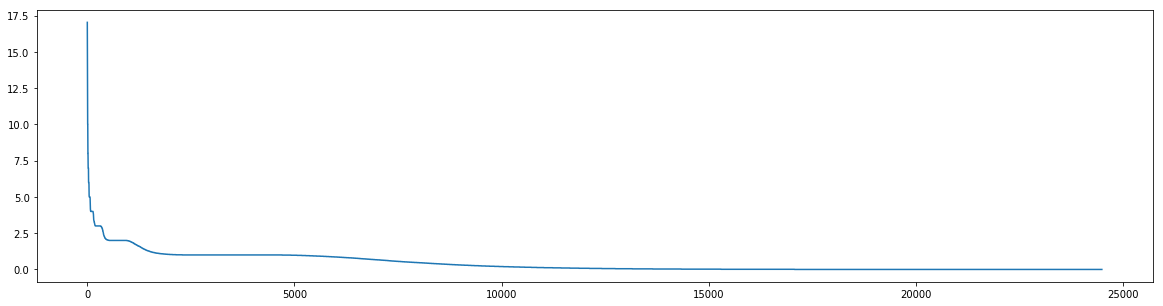

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["popularity"].values)

In [22]:
track_popularity.head()

,track,popularity
0,171,17.04
1,4186,16.00
2,1547,15.07
3,177,14.00
4,162,11.86


## Compute offline metrics

In [23]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [24]:
tracks = track_popularity["track"].tolist()

t_p_10_udf = spf.udf(lambda track: precision_at(tracks, track, 10))
st_10_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:10], track, 10))
st_100_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:100], track, 10))
st_1000_p_10_udf = spf.udf(lambda track: shuffled_precision_at(tracks[:1000], track, 10))


metrics = (
    data
        .filter(spf.col("rnd") <= 0.5)
        .filter(spf.col("time") >= 0.8)
        .select(
            t_p_10_udf(spf.col("track")).alias("t_p_10_udf"),
            st_10_p_10_udf(spf.col("track")).alias("st_10_p_10_udf"),
            st_100_p_10_udf(spf.col("track")).alias("st_100_p_10_udf"),
            st_1000_p_10_udf(spf.col("track")).alias("st_1000_p_10_udf")
        )
)

In [25]:
metrics.describe().toPandas()

,summary,t_p_10_udf,st_10_p_10_udf,st_100_p_10_udf,st_1000_p_10_udf
0,count,8089,8089,8089,8089
1,mean,8.159228582024974E-4,8.159228582024974E-4,4.821362343923849E-4,1.8543701322784028E-4
2,stddev,0.00899647494665875,0.00899647494665875,0.00692727222508606,0.004302511235059575
3,min,0.0,0.0,0.0,0.0
4,max,0.1,0.1,0.1,0.1


## Export data for prod

In [26]:
with open("../data/top_tracks.json", "w") as top_tracks_file:
    json.dump(tracks, top_tracks_file)